In [65]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [66]:
!nvidia-smi

Thu Sep  3 15:20:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 31%   43C    P2    36W / 250W |   6446MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

bur_vol_loss        0.365880
loss                0.060580
spin_loss           0.023966
val_bur_vol_loss    0.398604
val_loss            0.072824
val_spin_loss       0.031998
dtype: float64


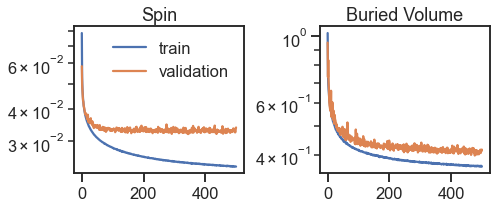

In [98]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))

log1 = pd.read_csv('20200901_combined_losses/log.csv').set_index('epoch')

axs[0].plot(log1['spin_loss'], label='train')
axs[0].plot(log1['val_spin_loss'], label='validation')
axs[0].set_title('Spin')

axs[1].plot(log1['bur_vol_loss'])
axs[1].plot(log1['val_bur_vol_loss'])
axs[1].set_title('Buried Volume')

for ax in axs:
    ax.set_yscale('log')
    
print(log1.min())
axs[0].legend()

plt.tight_layout()
# plt.xlim([0, 10])

In [99]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [101]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate

model = tf.keras.models.load_model(
    '20200901_combined_losses/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits,
                       'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

In [108]:
cdf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
cdf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_buried_volume.csv.gz', index_col=0)
cdf = cdf_spin.merge(cdf_bv, on=['smiles', 'atom_index'], how='left')

test = np.load('split.npz', allow_pickle=True)['test']

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [109]:
cdf_test = cdf[cdf.smiles.isin(test)].copy()
cdf_test['fractional_spin'] = cdf_test.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

atom_index,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
smiles,,,,,,,,,,,,,,,,,,,,,
CO/[C]=C1/CCCCC1=O,0.001776,0.103081,0.702058,0.109981,0.001902,0.002830,0.001808,0.005006,0.042844,0.010367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C[CH]C[C@@H]1COOO1,0.047013,0.718680,0.057055,0.019739,0.001834,0.000174,0.000294,0.000185,0.005816,0.043117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC[C@@H](F)C(=[N])N,0.000306,0.000109,0.074523,0.005681,0.122172,0.762786,0.020510,0.000498,0.000044,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[CH2]Nc1ccc(C)c(Cl)c1,0.597656,0.083265,0.045439,0.047257,0.023602,0.053582,0.002519,0.020194,0.000900,0.065124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NCc1nc[c]cc1F,0.000266,0.004885,0.036233,0.059242,0.046752,0.721763,0.058991,0.046018,0.003389,0.000182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
redf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins.csv.gz')
redf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_buried_volume.csv.gz')
redf = redf_spin.merge(redf_bv, on=['smiles', 'atom_index', 'atom_type'], how='left')
redf['fractional_spin'] = redf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

redf_test = np.load('redf_split.npz', allow_pickle=True)['test']
redf_smiles = redf.smiles.unique()

In [148]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [149]:
redf_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redf.smiles.unique()),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=redf.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [150]:
predicted_spin_logits, predicted_bur_vol = model.predict(test_dataset, verbose=1)
predicted_fractional_spins = tf.nn.softmax(predicted_spin_logits)

     16/Unknown - 2s 104ms/step

RDKit WARNING: [07:04:40] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:04:40]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [07:04:41] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:04:41]   BondStereo set to STEREONONE and single bond directions set to NONE.


40/40 [==============================] - 4s 102ms/step


Text(0.5, 1.0, 'Buried Volume')

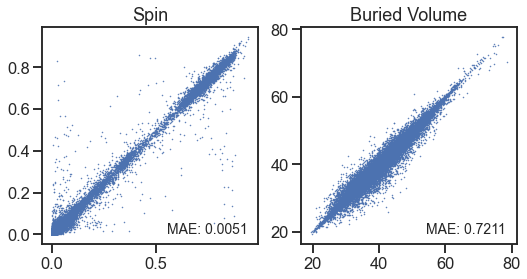

In [182]:
cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
cdf_test_pivot_spins = cdf_test_pivot_spins.reindex(test)

cdf_test_pivot_bur_vol = cdf_test.pivot(index='smiles', columns='atom_index', values='buried_vol')
cdf_test_pivot_bur_vol = cdf_test_pivot_bur_vol.reindex(test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(cdf_test_pivot_spins.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_spins.values.flatten() - predicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(cdf_test_pivot_bur_vol.values.flatten(), predicted_bur_vol.flatten(), '.', ms=1)
axs[1].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_bur_vol.values.flatten() - predicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [183]:
rpredicted_spin_logits, rpredicted_bur_vol = model.predict(redf_dataset, verbose=1)
rpredicted_fractional_spins = tf.nn.softmax(rpredicted_spin_logits)

     54/Unknown - 5s 97ms/step

RDKit WARNING: [07:12:04] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:12:04]   BondStereo set to STEREONONE and single bond directions set to NONE.


    107/Unknown - 11s 100ms/step

RDKit WARNING: [07:12:10] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [07:12:10]   BondStereo set to STEREONONE and single bond directions set to NONE.


115/115 [==============================] - 11s 99ms/step


Text(0.5, 1.0, 'Buried Volume')

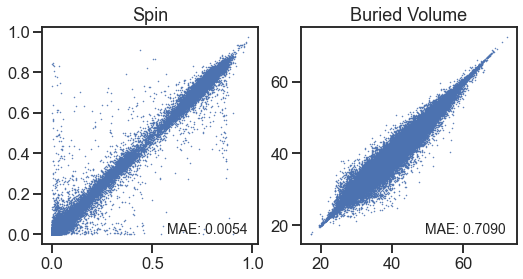

In [189]:
redf_pivot_spins = redf.pivot(index='smiles', columns='atom_index', values='fractional_spin')
redf_pivot_spins = redf_pivot_spins.reindex(redf_smiles)

redf_pivot_bur_vol = redf.pivot(index='smiles', columns='atom_index', values='bur_vol')
redf_pivot_bur_vol = redf_pivot_bur_vol.reindex(redf_smiles)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(redf_pivot_spins.values.flatten(), rpredicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(redf_pivot_spins.values.flatten() - rpredicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(redf_pivot_bur_vol.values.flatten(), rpredicted_bur_vol.flatten(), '.', ms=1)
axs[1].text(.95, .05, f'MAE: {pd.Series(redf_pivot_bur_vol.values.flatten() - rpredicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [190]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate

redox_model = tf.keras.models.load_model(
    '20200903_xfer_h2o_noinit/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits,
                       'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

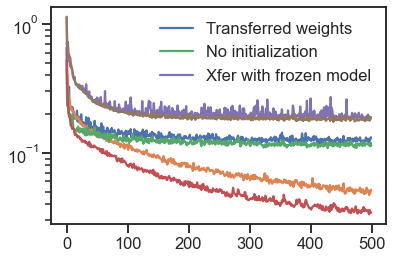

In [191]:
log = pd.read_csv('20200903_xfer_h2o/log.csv').set_index('epoch')
plt.semilogy(log['val_redox_loss'], label='Transferred weights')
plt.semilogy(log['redox_loss'])

log = pd.read_csv('20200903_xfer_h2o_noinit/log.csv').set_index('epoch')
plt.semilogy(log['val_redox_loss'], label='No initialization')
plt.semilogy(log['redox_loss'])

log = pd.read_csv('20200903_xfer_h2o_frozen/log.csv').set_index('epoch')
plt.semilogy(log['val_redox_loss'], label='Xfer with frozen model')
plt.semilogy(log['redox_loss'])

plt.legend()

In [196]:
_, _, redox_predictions = redox_model.predict(redf_dataset, verbose=1)

     54/Unknown - 5s 100ms/step

RDKit WARNING: [08:16:31] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:16:31]   BondStereo set to STEREONONE and single bond directions set to NONE.


    106/Unknown - 11s 103ms/step

RDKit WARNING: [08:16:36] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [08:16:36]   BondStereo set to STEREONONE and single bond directions set to NONE.


115/115 [==============================] - 12s 102ms/step


In [197]:
# Load redox properties
redf_redox = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_redox.csv.gz')
redf_redox = redf_redox.set_index('smiles').reindex(redf_smiles)    

In [207]:
redf_redox['electron affinity'] - redox_predictions[:, 1]

smiles
[CH2]C1=COCC1                -0.003478
CC[C@H](C)C[CH]CCO                 NaN
CS[C@H]1CC[C@@H]1NC1[CH]C1   -0.010194
COC(C)[O]                     0.074414
[CH2]CCCCOC/C=C/C             0.011201
                                ...   
C=CC[CH]C=C(C)C               0.012905
[CH2][C@@H]1CCC[C@@H](C)C1   -0.049402
C=CO[C@H](C)[C](C)C           0.019942
[CH2][C@@H]1CCC[C@H](O)C1     0.028653
CO[C](C)C(C)C                -0.026339
Name: electron affinity, Length: 14599, dtype: float64

In [212]:
redf_redox['ie_pred'] = redox_predictions[:, 0]
redf_redox['ea_pred'] = redox_predictions[:, 1]

In [222]:
redf_valid = np.load('redf_split.npz', allow_pickle=True)['valid']

In [225]:
redox_test = redf_redox.reindex(np.concatenate([redf_test, redf_valid]))

Text(0.95, 0.05, 'MAE: 0.086')

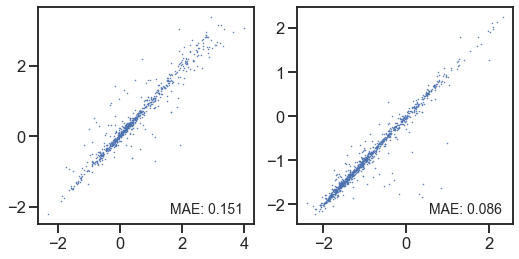

In [226]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(redox_test['ionization energy'], redox_test['ie_pred'], '.', ms=1)
axs[1].plot(redox_test['electron affinity'], redox_test['ea_pred'], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_test['ionization energy'] - redox_test['ie_pred']).dropna().abs().mean():.3f}", ha='right',
            transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_test['electron affinity'] - redox_test['ea_pred']).dropna().abs().mean():.3f}", ha='right',
            transform=axs[1].transAxes, fontsize=14)

smiles
CC1=C[C@@H]([O])CCC1        0.020871
[CH2][C@H](O)C(=O)C1CC1          NaN
Cc1ccc([C]=O)c(O)c1         0.017444
[CH2]C=C=O                  0.022601
CC/C=[C]\C[C@@H]1CO1        0.011629
                              ...   
C=C(CCC)CC[O]               0.002524
[CH2]C(C)(C)OC[C@H](O)CO         NaN
[NH]NN=O                         NaN
[CH]=C[C@H](C)[C@H](C)CO         NaN
C[C](O)C[C@@H]1CO1          0.093270
Length: 1000, dtype: float64

Text(0, 0.5, 'Electron affinity error')

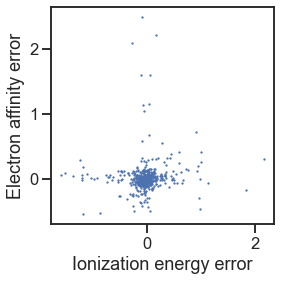

In [237]:
plt.figure(figsize=(4,4))
plt.plot((redox_test['ionization energy'] - redox_test['ie_pred']), 
         (redox_test['electron affinity'] - redox_test['ea_pred']), '.', ms=2.5)
plt.xlabel('Ionization energy error')
plt.ylabel('Electron affinity error')

In [241]:
(redox_test['ionization energy'] - redox_test['ie_pred']).abs().sort_values(ascending=False)

smiles
[CH2]C(=O)[C@H](C)SCCCO          2.163346
CS[C@H](C)C(=O)[N]C1CC1          1.828163
[CH2]S(=O)(=O)[C@@H](C)C(C)=O    1.578810
C[N+](C)(C)CCSC(=[N])N           1.504772
C=[C]CC(C(=O)O)C(=O)O            1.363854
                                   ...   
[CH2]C(=O)CCC[C@@H](O)CC              NaN
C/C(=N/O)C1[CH]C1                     NaN
[CH2]C(C)(C)OC[C@H](O)CO              NaN
[NH]NN=O                              NaN
[CH]=C[C@H](C)[C@H](C)CO              NaN
Length: 1000, dtype: float64

In [242]:
(redox_test['electron affinity'] - redox_test['ea_pred']).abs().sort_values(ascending=False)

smiles
C=C(C[CH]CC)OC=O               2.491680
O=C1CCC[CH]CC[C@@H]1O          2.217799
CCC(=O)OCC[CH]O                2.087794
[CH2]CC1CC(=O)CC(=O)C1         1.936857
[CH2]C(/C=C/[N+](=O)[O-])CC    1.602477
                                 ...   
CC(=O)O[C@@H]1[CH]OCCO1             NaN
CCC[C@@H](C)S[C@H](C)[CH]O          NaN
[CH2][C@@H](CCO)SCCSC               NaN
COC[C@H](C)NC[CH]CS                 NaN
[C]1=CO1                            NaN
Length: 1000, dtype: float64